# 线性回归的从零开始实现

In [363]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 1. 生成数据集

为了简单起见，我们将根据带有噪声的线性模型构造一个人造数据集。我们的任务是使用这个有限样本的数据集来恢复这个模型的参数。

In [364]:
def synthetic_data(w, b, num_example):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0,1,(num_example,w.shape[0]))
    y = torch.matmul(X,w) + b
    y += torch.normal(0,0.01,y.shape)
    return X, y.reshape((-1,1))

true_w = torch.tensor((2,-3.4))
true_b = torch.tensor(4.2)
features, labels = synthetic_data(true_w, true_b,1000)

注意，features中的每一行都包含一个二维数据样本， labels中的每一行都包含一维标签值（一个标量）。

通过生成第二个特征features[:, 1]和labels的散点图， 可以直观观察到两者之间的线性关系。

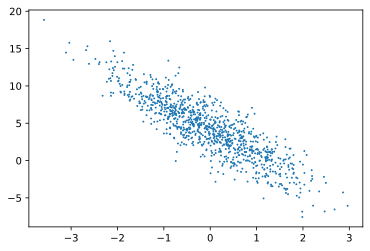

In [365]:
from matplotlib import pyplot as plt
plt.scatter(features[:,1],labels,1)

### 2. 读取数据集


回想一下，训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。 由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数， 该函数能打乱数据集中的样本并以小批量方式获取数据。

In [366]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size,num_examples)])
        yield features[batch_indices], labels[batch_indices]


我们直观感受一下小批量运算：读取第一个小批量数据样本并打印。 每个批量的特征维度显示批量大小和输入特征数。 同样的，批量的标签形状与batch_size相等。

In [367]:
batch_size = 10
for X, y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break

tensor([[ 0.7953,  0.2015],
        [ 0.1325,  0.7237],
        [-1.3267,  1.4790],
        [ 0.9398,  0.6349],
        [ 1.2949,  0.7367],
        [-1.3010,  1.9186],
        [-0.5695,  0.9714],
        [-0.8137,  0.7208],
        [ 0.0891,  0.9263],
        [ 0.0812,  0.9013]]) 
 tensor([[ 5.1063],
        [ 1.9967],
        [-3.4818],
        [ 3.9082],
        [ 4.2829],
        [-4.9390],
        [-0.2248],
        [ 0.1292],
        [ 1.2329],
        [ 1.3006]])


### 3. 初始化模型参数

在我们开始用小批量随机梯度下降优化我们的模型参数之前， 我们需要先有一些参数。 在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重， 并将偏置初始化为0。

In [368]:
w = torch.normal(0,0.01,(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

### 4. 定义模型

In [369]:
def linreg(X,w,b):  #@save
    """线性回归模型"""
    return torch.matmul(X,w) + b

### 5. 定义损失函数

In [370]:
def squared_loss(y_hat,y): #@save
    """均方损失"""
    return (y_hat - y) ** 2 / 2


### 6. 定义优化算法

小批量随机梯度下降

In [371]:
def sgd(params, lr, batch_size):    #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 7. 训练

在每个迭代周期（epoch）中，我们使用data_iter函数遍历整个数据集， 并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。 这里的迭代周期个数num_epochs和学习率lr都是超参数，分别设为3和0.03。 设置超参数很棘手，需要通过反复试验进行调整。 

In [372]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size,features,labels):
        y_hat = net(X,w,b)
        l = loss(y_hat,y)   # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch:{epoch + 1}, loss:{float(train_l.mean()):.5f}')

        

epoch:1, loss:0.03429
epoch:2, loss:0.00013
epoch:3, loss:0.00005


因为我们使用的是自己合成的数据集，所以我们知道真正的参数是什么。 因此，我们可以通过比较真实参数和通过训练学到的参数来评估训练的成功程度。 事实上，真实参数和通过训练学到的参数确实非常接近。

In [373]:
print('w的估计误差:',[f'{i:.5f}' for i in (true_w - w.reshape(true_w.shape)).detach().reshape(-1).tolist()])
print('b的估计误差:',[f'{(true_b - b).item():.5f}'])

w的估计误差: ['0.00078', '-0.00122']
b的估计误差: ['0.00051']
